In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 38.1 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [3]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [4]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

# env = gym.make('CartPole-v1')
env = gym.make('Acrobot-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")


6
3
1
----
[ 0.99962485  0.02738891  0.9989402  -0.04602639 -0.09180529 -0.09669447]
----
0
----
[ 0.9998245   0.01873245  0.995746   -0.09214022  0.00529764 -0.3585254 ]
-1.0
False
{}
----


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


In [9]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


class DuelingDQN(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(DuelingDQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc_value = nn.Linear(128, 1)
        self.fc_advantage = nn.Linear(128, action_size)

        # self.update_type = update_type

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        value = self.fc_value(x)
        advantage = self.fc_advantage(x)

        Q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        # elif self.update_type == 'Type-2':
        #   Q_values = value + (advantage - advantage.max(dim=1, keepdim=True)[0])
        # else:
        #   raise ValueError("Invalid Input of Type")

        return Q_values

In [10]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [11]:
class DQNAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = DuelingDQN(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingDQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

In [13]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores_window = []
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        # if i_episode % 100 == 0:
        #    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # if np.mean(scores_window)>=195.0:
        #    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        #    break
    return scores_window

''' Trial run to check if algorithm runs and saves the data '''
Experiments = 5
begin_time = datetime.datetime.now()
TT_type_1 = np.zeros([Experiments,1000])
# TT_type_2 = np.zeros([Experiments,1000])
env = gym.make('Acrobot-v1')
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
for i in range(Experiments):
  env.seed(i)
  np.random.seed(i)
  agent = DQNAgent(state_size=state_shape, action_size = action_shape, seed = i)
  TT_type_1[i,:] = dqn()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 1000	Average Score: -144.27

In [14]:
class DuelingDQN(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(DuelingDQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc_value = nn.Linear(128, 1)
        self.fc_advantage = nn.Linear(128, action_size)

        # self.update_type = update_type

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        value = self.fc_value(x)
        advantage = self.fc_advantage(x)

        # Q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        # elif self.update_type == 'Type-2':
        Q_values = value + (advantage - advantage.max(dim=1, keepdim=True)[0])
        # else:
        #   raise ValueError("Invalid Input of Type")

        return Q_values

In [20]:
Experiments = 5
begin_time = datetime.datetime.now()
# TT_type_1 = np.zeros([Experiments,1000])
TT_type_2 = np.zeros([Experiments,1000])
env = gym.make('Acrobot-v1')
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

for i in range(Experiments):
  env.seed(i)
  np.random.seed(i)
  agent = DQNAgent(state_size=state_shape, action_size = action_shape, seed = i)
  TT_type_2[i,:] = dqn()

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 1000	Average Score: -122.422:39:21.063214


In [25]:
def final_plot(TT_type_1, TT_type_2):
  import matplotlib.pyplot as plt
  TT1_mean = np.mean(TT_type_1, axis = 0)
  TT1_std = np.std(TT_type_1, axis = 0)


  TT2_mean = np.mean(TT_type_2, axis = 0)
  TT2_std = np.std(TT_type_2, axis = 0)


  # Plotting
  plt.figure(figsize=(10, 6))

  # Plot Type-1 scores
  plt.plot(TT1_mean, label='Type-1 Dueling DQN', color='blue')
  plt.fill_between(range(len(TT1_mean)),
                  TT1_mean - TT1_std,
                  TT1_mean + TT1_std,
                  alpha=0.3, color='blue')

  # Plot Type-2 scores
  plt.plot(TT2_mean, label='Type-2 Dueling DQN', color='red')
  plt.fill_between(range(len(TT2_mean)),
                  TT2_mean - TT2_std,
                  TT2_mean + TT2_std,
                  alpha=0.3, color='red')

  # Plot labels and legend
  plt.title('Comparison of Type-1 and Type-2 Dueling DQN')
  plt.xlabel('Episodes')
  plt.ylabel('Average Score')
  plt.legend()

  # Show plot
  plt.show()

  return True


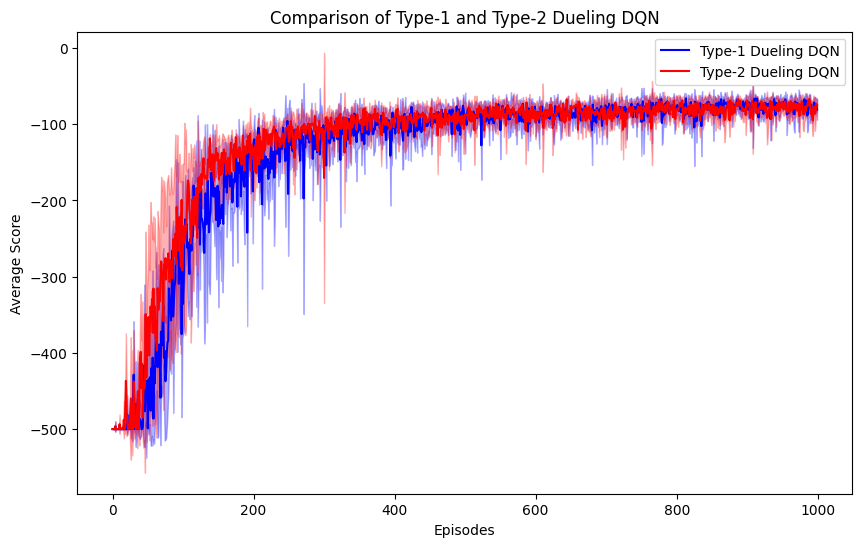

True

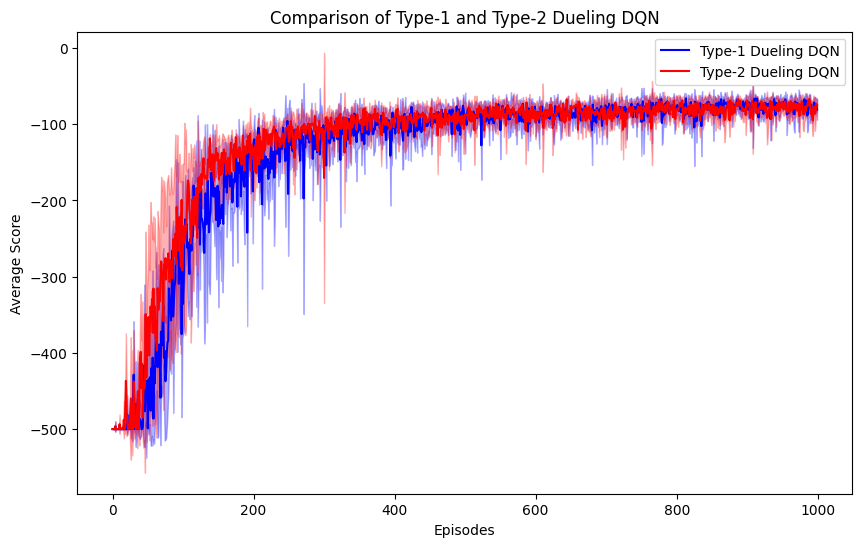

True

In [26]:
final_plot(TT_type_1, TT_type_2)

In [27]:
TT_type_1.shape

(5, 1000)

(5, 1000)

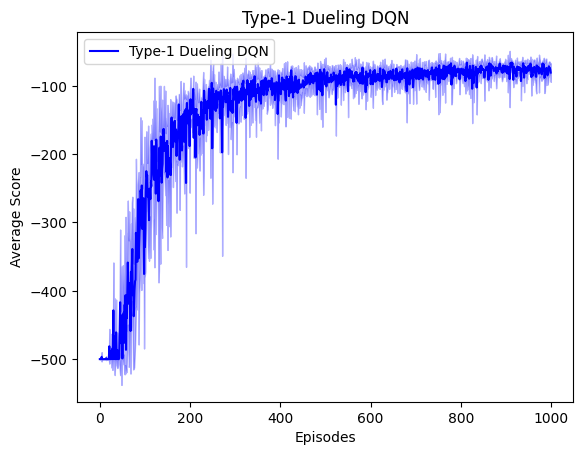

In [29]:
import matplotlib.pyplot as plt
TT1_mean = np.mean(TT_type_1, axis = 0)
TT1_std = np.std(TT_type_1, axis = 0)


TT2_mean = np.mean(TT_type_2, axis = 0)
TT2_std = np.std(TT_type_2, axis = 0)


# Plotting
# plt.figure(figsize=(10, 6))

# Plot Type-1 scores
plt.plot(TT1_mean, label='Type-1 Dueling DQN', color='blue')
plt.fill_between(range(len(TT1_mean)),
                TT1_mean - TT1_std,
                TT1_mean + TT1_std,
                alpha=0.3, color='blue')

plt.title('Type-1 Dueling DQN')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.legend()

# # Plot Type-2 scores
# plt.plot(TT2_mean, label='Type-2 Dueling DQN', color='red')
# plt.fill_between(range(len(TT2_mean)),
#                 TT2_mean - TT2_std,
#                 TT2_mean + TT2_std,
#                 alpha=0.3, color='red')

# # Plot labels and legend
# plt.title('Type-2 Dueling DQN')
# plt.xlabel('Episodes')
# plt.ylabel('Average Score')
# plt.legend()

# # Show plot
# plt.show()

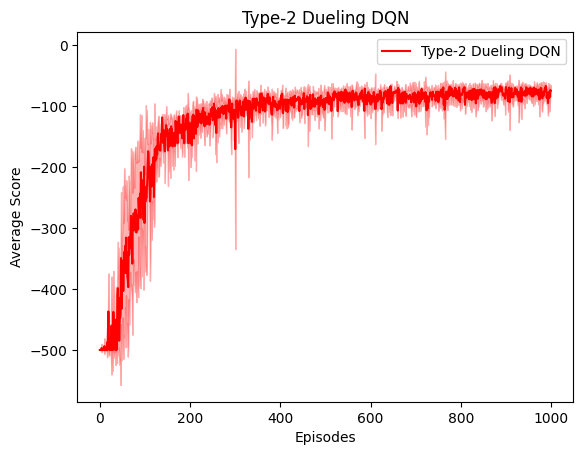

In [30]:
# Plot Type-2 scores
plt.plot(TT2_mean, label='Type-2 Dueling DQN', color='red')
plt.fill_between(range(len(TT2_mean)),
                TT2_mean - TT2_std,
                TT2_mean + TT2_std,
                alpha=0.3, color='red')

# Plot labels and legend
plt.title('Type-2 Dueling DQN')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.legend()

# Show plot
plt.show()

In [2]:
import matplotlib.pyplot as plt
t = np.arange(1000)
plt.plot(t, TT)

NameError: name 'np' is not defined

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import datetime

# Define dueling DQN architecture
class DuelingDQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_value = nn.Linear(64, 1)
        self.fc_advantage = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc_value(x)
        advantage = self.fc_advantage(x)
        Q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return Q_values

class DuelingDQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, epsilon=1, epsilon_decay=0.995, epsilon_min=0.01, batch_size=64, buffer_size=10000, update_freq=100):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.update_freq = update_freq
        self.q_network = DuelingDQN(state_size, action_size)
        self.target_network = DuelingDQN(state_size, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.steps = 0

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state)
            return torch.argmax(q_values, dim=1).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states)
        target_q_values = self.target_network(next_states).detach()

        target = rewards + self.gamma * torch.max(target_q_values, dim=1)[0] * (1 - dones)
        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        loss = self.loss_fn(q_value, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps % self.update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        self.steps += 1
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores_window = deque(maxlen=100)
    scores = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):

        state = env.reset()
        score = 0

        for t in range(max_t):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        # if i_episode % 100 == 0:
        #     print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # if np.mean(scores_window) >= 500:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        #     break

    return scores

# Initialize environment and agent
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DuelingDQNAgent(state_size, action_size)

# Train the agent
begin_time = datetime.datetime.now()
scores = dqn()
time_taken = datetime.datetime.now() - begin_time
print("\nTime taken:", time_taken)

# Plot the scores
import matplotlib.pyplot as plt
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Dueling DQN for CartPole-v1')
plt.show()
